This project demonstrates the use of SQL (sqlite3) in conjunction with Python. The database used is the CIA World Factbook and write queries to see if we can draw any interesting insights.

In [22]:
import pandas as pd
import sqlite3
import numpy as np

In [6]:
#connect and see what tables we have
conn = sqlite3.connect("factbook.db")
q = "SELECT * FROM sqlite_master WHERE type='table';" 
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


In [7]:
#browse first five columns, same as df.head(5)
query = "select * from facts LIMIT 5;"
"""cursor.execute(query)
first_five = cursor.fetchall()
print(first_five)"""
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


In [8]:
#see what max and minimum population are
query1 = "select MIN(population), max(population), min(population_growth), max(population_growth) from facts;"
pd.read_sql_query(query1, conn)

,MIN(population),max(population),min(population_growth),max(population_growth)
0,0,7256490011,0.0,4.02


Minimum population is zero, and max population is > 7,000,000,000, so something isn't quite right

In [9]:
#find out the name of the country which has a population of zero
query2 = "select name from facts where population = 0;"
pd.read_sql_query(query2, conn)

,name
0,Antarctica


In [10]:
#find out which country has over 7,000,000,000 people
query3 = "select name from facts where population = (select max(population) from facts);"
pd.read_sql_query(query3, conn)

,name
0,World


There are country entries for Antarctica and the world, which need to be removed for calculations

In [14]:
q4 = '''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
'''

data = pd.read_sql_query(q4, conn)
data.head()

,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31
3,85580,0.12,8.13,6.96
4,19625353,2.78,38.78,11.49


Plot histograms of key columns:

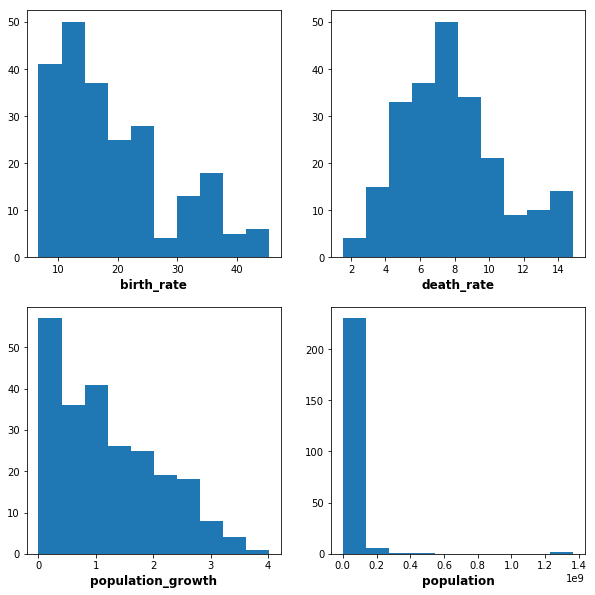

In [20]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

data["birth_rate"].hist(ax=ax1)
ax1.set_xlabel("birth_rate", fontweight= 'bold', fontsize = 12)
ax1.grid(False)
data["death_rate"].hist(ax=ax2)
ax2.set_xlabel("death_rate", fontweight= 'bold', fontsize = 12)
ax2.grid(False)
data["population_growth"].hist(ax=ax3)
ax3.set_xlabel("population_growth", fontweight= 'bold', fontsize = 12)
ax3.grid(False)
data["population"].hist(ax=ax4)
ax4.set_xlabel("population", fontweight= 'bold', fontsize = 12)
ax4.grid(False)

plt.show()

It's a bit pointless displaying population in this way, but we'll get a better idea of the distribution with a log transform

In [23]:
data['population_log'] = np.log(data['population'])
data.head()

,population,population_growth,birth_rate,death_rate,population_log
0,32564342,2.32,38.57,13.89,17.298728
1,3029278,0.30,12.92,6.58,14.923835
2,39542166,1.84,23.67,4.31,17.492878
3,85580,0.12,8.13,6.96,11.357207
4,19625353,2.78,38.78,11.49,16.792333


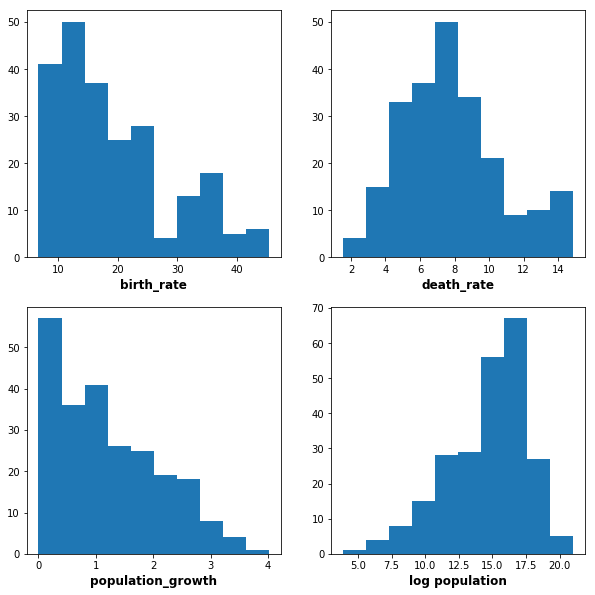

In [24]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

data["birth_rate"].hist(ax=ax1)
ax1.set_xlabel("birth_rate", fontweight= 'bold', fontsize = 12)
ax1.grid(False)
data["death_rate"].hist(ax=ax2)
ax2.set_xlabel("death_rate", fontweight= 'bold', fontsize = 12)
ax2.grid(False)
data["population_growth"].hist(ax=ax3)
ax3.set_xlabel("population_growth", fontweight= 'bold', fontsize = 12)
ax3.grid(False)
data["population_log"].hist(ax=ax4)
ax4.set_xlabel("log population", fontweight= 'bold', fontsize = 12)
ax4.grid(False)

plt.show()

The birth_rate and population growth look to be correlated, which makes sense. Death rates are approximately normally distributed around a mean of about 8 per 1000 people per year. The log transform shows that populations are left-skewed

Next we want to know what city has the highest population density

In [25]:
q5 = '''
SELECT name, CAST(population as float)/CAST(area as float) "density"
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
ORDER BY density DESC
'''

data = pd.read_sql_query(q5, conn)
data.head()

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444


Macau is highest, with 21,169 people per square kilometre, although this value is most likely skewed since tourists are included in calculations

Let's visualise the distribution of the densities

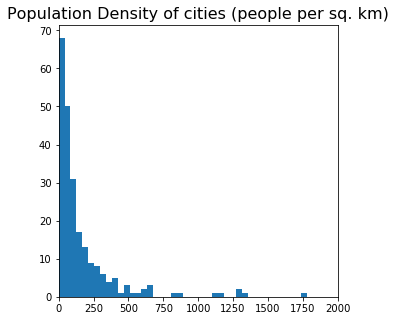

In [33]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

data['density'].hist(bins=500)
ax.set_xlim(0, 2000)
ax.grid(False)
ax.set_title("Population Density of cities (people per sq. km)", fontsize = 16)
plt.show()

As expected, values are generally low and the distribution is skewed to the right